# Lab Exercise 5: QAM-PSK

```{image} ../content/images/QAM16_Demonstration.gif
:align: center
```

```{admonition} Live Code
Press the following button to make python code interactive. It will connect you to a kernel once it says "ready" (might take a bit, especially the first time it runs).
```

<div style="text-align: center;">
  <button title="Launch thebe" class="thebelab-button thebe-launch-button" onclick="initThebe()">Python Interactive Code</button>
</div>


## Questions 
 <font size="3">1  ) Plot a 64-QAM signal constellation of a complete rectangular grid, with the binary words next to each of its points marked [as in figure 5.4(b) of the Course Notes] with Gray coding.</font>


Hint: Use the section of commands 26-34 from Code 5.2 of the Course Notes (repeated below,
for convenience) to produce a mapping vector containing all points of the signal constellation
in ascending codeword order: mapping(1) -> 00..00, mapping (2)->00..01, … With the
scatterplot() command, plot the points of the signal constellation and with appropriate
text addition commands write near each point the corresponding code word [e.g. the
command text(3,3,num2str(de2bi(4,3,'left-msb')), 'FontSize', 6); writes
the codeword “1 0 0” at point (3,3) of the figure with font size 6].


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import VBox, Output, Dropdown
import ipywidgets as widgets
import random
import scipy.signal
from math import log
import array
from scipy.signal import upfirdn,decimate
from scipy.special import erfc

`````{tab} Python
````python
# The mapping vector for M-QAM Gray coding
# It is for a complete rectangular constellation, of dimension M=L^2
# l=log2(L): number of bits per dimension (inphase, quadrature)
core = np.array([1+1j, 1-1j, -1+1j, -1-1j]) # trivial case, M=4
mapping = core

if (l > 1):
    for k in range (1,l):
        mapping = mapping + k*2*core[0]
        mapping = np.array([mapping, np.conj(mapping)])
        mapping = np.array([mapping, (-np.conj(mapping))])
        
mapping = mapping.flatten().T

````
`````
`````{tab} Matlab
````matlab

% The mapping vector for M-QAM Gray coding
% It is for a complete rectangular constellation, of dimension M=L^2
% l=log2(L): number of bits per dimension (inphase, quadrature)
core=[1+i;1-i;-1+i;-1-i]; % trivial case, M=4
mapping=core;
if(l>1)
 for j=1:l-1
 mapping=mapping+j*2*core(1);
 mapping=[mapping;conj(mapping)];
 mapping=[mapping;-conj(mapping)];
 end
end;


````
`````

In [2]:
def plot_qam_constellation(L):
    M = L * L
    l = int(np.log2(L))
    
    # Core QAM constellation points
    core = np.array([1+1j, 1-1j, -1+1j, -1-1j])
    mapping = core

    if (l > 1):
        for k in range (1,l):
            mapping = mapping + k*2*core[0]
            mapping = np.array([mapping, np.conj(mapping)])
            mapping = np.array([mapping, (-np.conj(mapping))])
            
    mapping = mapping.flatten().T

    # Gray code labels
    labels = [bin(i)[2:].zfill(2 * l) for i in range(M)]

    # Plotting the constellation
    with out:
        out.clear_output(wait=True)
        plt.figure(figsize=(10, 7))
        plt.scatter(mapping.real, mapping.imag)
        dx, dy = -0.5, 0.3  # Label offsets
        for i in range(len(labels)):
            plt.text(mapping[i].real + dx, mapping[i].imag + dy, labels[i], bbox=dict(facecolor='red', alpha=0.5))
        
        plt.grid(True)
        plt.xlim(-1 * L, 1 * L)
        plt.ylim(-1 * L, 1 * L)
        plt.title(f"{L}x{L} QAM Constellation")
        plt.xlabel("In-phase")
        plt.ylabel("Quadrature")
        plt.show()

# Dropdown for selecting L
L_dropdown = Dropdown(options=[2, 4, 8], value=8, description='Select L:')

# Output widget for the plot
out = Output()

# Display widgets
vbox = VBox([L_dropdown, out])
display(vbox)

# Update plot based on dropdown selection
def on_value_change(change):
    plot_qam_constellation(change['new'])

L_dropdown.observe(on_value_change, names='value')

# Initial plot
plot_qam_constellation(L_dropdown.value)

<font size="3"> 2)We have available the 6.75-9.25 MHz bandpass channel and want to transmit
at a rate of 10 Mbps. Select a complete rectangular constellation and Nyquist
signaling M-QAM system suitable for this purpose. Choose the smallest
possible M and an appropriate roll-off value to take advantage of all available
bandwidth. Simulate transmitter and receiver and plot the Pb vs Eb/No curve
theoretically and experimentally. The sampling frequency must be sufficiently
high so that the signals of all modulation-demodulation stages can be
represented without aliasing.</font>
    
Connection with theory: The transmission rate, R (bits/s), is related to the symbol rate, 1/Τ
(also called baud rate) and the size of the signal constellation, M, with the relation
$$

\frac{R}{\log_2 L} = \frac{l}{T} 

$$

On the other hand, the required bandwidth for bandpass transmission with Nyquist signaling
is equal to
$$

W = \frac{1}{T}(1+\alpha)

$$
where α is the roll-off factor of the Nyquist filter used. Combining the
above relations, we conclude that the size of the constellation must satisfy the inequality: 
$$

log_2 M >= \frac{R}{W}(1+\alpha), 0<a<=1

$$


```{image} ../content/images/Lab5_1.png
:align: center
```

In [3]:
W=(9.25-6.75)*(10**6)
R=12*(10**6)
M=2**(R/W)
M=64 #θέλουμε να είναι πλήρους ορθογωνικού πλέγματος οπότε επιλέγουμε αυτή την τιμή 
a=np.log2(M)*W/R-1
print("Result: a =", a) #roll-off



Result: a = 0.25


Result: a = 0.25

In [4]:
def rootRaisedCosine(nsamp, roll_off, delay):
    F0 = 0.5 / nsamp
    Fd = 1
    Fs = Fd * nsamp
    Td = 1 / Fd
    Ts = 1 / Fs
    F1 = F0 * (1 - roll_off)
    F2 = F0 * (1 + roll_off)
    filter_order = 2 * nsamp * delay

    t = np.arange(0, filter_order, Td)
    h = []
    for i in range(len(t)):
        t_shifted = t[i] - filter_order / 2
        if t_shifted == 0:
            h.append(np.sqrt(2 * F0) *(1 + roll_off * ((4 / np.pi) - 1)))
        elif t_shifted == 1 / 8 / roll_off / F0 or t_shifted == - 1 / 8 / roll_off / F0 :
            h.append((roll_off * np.sqrt(F0)) * ((1 + 2 / np.pi) * np.sin(np.pi / 4 / roll_off) + (1 - 2 / np.pi) * np.cos(np.pi / 4 / roll_off)))
        else:
            factor1 = np.sqrt(2 * F0) / (1 - 64 * roll_off* roll_off * F0 * F0 * t_shifted * t_shifted)
            factor2 = np.sin(2 * np.pi * F1 * t_shifted) / (2 * np.pi * F0 * t_shifted)
            factor3 = (4 * roll_off / np.pi) * np.cos(2 * np.pi * F2 * t_shifted) 
            h.append(factor1 * (factor2 + factor3))


  #  plt.plot(t,h)
   # plt.grid()
    #plt.show()
    
    return h

def ber_64qam(EbNo):
    a=0.25
    L=8
    l=np.log2(L)
    k=2*l
    M=64
    Nsymb=30000
    # προσομοίωση πομπού
    nsamp=16
    fc=4
    SNR=EbNo-10*np.log10(nsamp/k/2) #σε db
    core=[1+1j,1-1j,-1+1j,-1-1j]
    mapping=core[:]
    if(l>1):
        for j in range(1,int(l)):
            mapping=(list(map(lambda x:x+j*2*core[0],mapping)))
            conj_arr=np.conj(mapping)
            mapping= mapping + conj_arr.tolist()
            conj_arr=-np.conj(mapping)
            mapping= mapping + conj_arr.tolist()
            
    #παράγουμε τυχαία ακολουθία
    x=np.floor(2*np.random.rand(int(k*Nsymb),1))
    x_temp=np.reshape(x,(int(len(x)/(k)),int(k)))
    xsym=[]

    # χωρίζω τη λίστα σε επιμέρους λίστες και βάζω τα περιεχόμενα 
    #της καθεμίας σε ένα string ώστε με την εντολή int() να 
    # μετατραπεί από binary σε decimal
    for i in range(0,len(x_temp)):
        my_str=''
        y=x_temp[i]
        for j in range(0,int(np.log2(M))):
            my_str=my_str+str(int(y[j]))
        a=int(my_str, 2)
        xsym=xsym+[a]

    y=[]
    for n in range(0,len(xsym)):
        y=y + [mapping[xsym[n]]]
    
    delay=10
    filtorder= delay*nsamp*2
    rolloff=0.25

    shaping_filter=rootRaisedCosine(nsamp, rolloff, delay)
    ytx=upfirdn([1], y, nsamp) #upsample
    ytx=np.convolve(ytx,shaping_filter)
    m=np.arange(1,len(ytx)+1)
    s=np.real(np.multiply(ytx,np.exp(1j*2*np.pi*fc*m/nsamp)))
    
    s_matrix=np.matrix(s) #ανάστροφος
    s_matrix=s_matrix.getH()
    s_list=s_matrix.tolist()
    Ps=10*np.log10(np.matmul(s,s_list)/len(s)) #ισχύς μιγαδικού σήματος σε db
    Pn=Ps-SNR

    n=np.sqrt(10**(Pn/10))*np.random.randn(1,len(ytx))
    snoisy=s+n
    
    #δέκτης
    yrx=2*np.multiply(snoisy,np.exp(-1j*2*np.pi*fc*m/nsamp))
    yrx=yrx[0,:]
    yrx=np.convolve(yrx,shaping_filter)
    yrx=yrx[::nsamp] #downsample 
    
    yrx=yrx[2*delay+0:len(yrx)-2*delay]
    
    yi=yrx.copy()
    yq=np.imag(yi)
    yi=np.real(yi)
    
    xrx=[]
    q=np.arange(-L+1,L,2)

    for n in range(len(yrx)):
        differences = np.abs(q-yi[n]) # Πίνακας με τις διαφορές του σήματος από τα επίπεδα
        m = min(differences)
        [index], = np.where(differences == m)
        yi[n] = q[index]
        differences = np.abs(q-yq[n]) # Πίνακας με τις διαφορές του σήματος από τα επίπεδα
        m = min(differences)
        [index], = np.where(differences == m)
        yq[n] = q[index]
    error = 0
    for i in range(len(yrx)):
        if y[i] != yi[i]+yq[i]*1j:
            error += 1 
    return (error/len(x))
    
ber_exp=[]
ber_th=[]
for i in range(1,15):
    ber_exp=ber_exp+[ber_64qam(i)]
    ber_th = ber_th +[((L - 1) /(L*np.log2(L)) * scipy.special.erfc(np.sqrt(3 * np.log2(L) / (L * L - 1) * 10**(i/10))))]

plt.figure(figsize=(18, 16))
plt.semilogy(ber_exp,'o')
plt.semilogy(ber_th)
plt.legend(['Simulation', 'Theoretical'])
plt.xlabel('Eb/N0(db)')
plt.ylabel('Bit Error Probability')
plt.title('BER curve for 64-QAM')
plt.grid(which='both')
plt.show()

NameError: name 'L' is not defined

<font size="3">  3) If, for the system in question 2, the maximum normalized signal-to-noise ratio,
Eb/No, that you can achieve at the receiver, is 10 db, and the channel encoder
you have requires that the bit error probability does not exceed 0.005, fall back
into a lower-order, rectangular grid QAM system again, without changing the
other signaling parameters. What is the maximum baud rate now? Plot the
power spectrum density of your signals again and see if there are any
differences. Examine if a less fall back in a non-rectangular grid system could
satisfy the required transmission quality..</font>

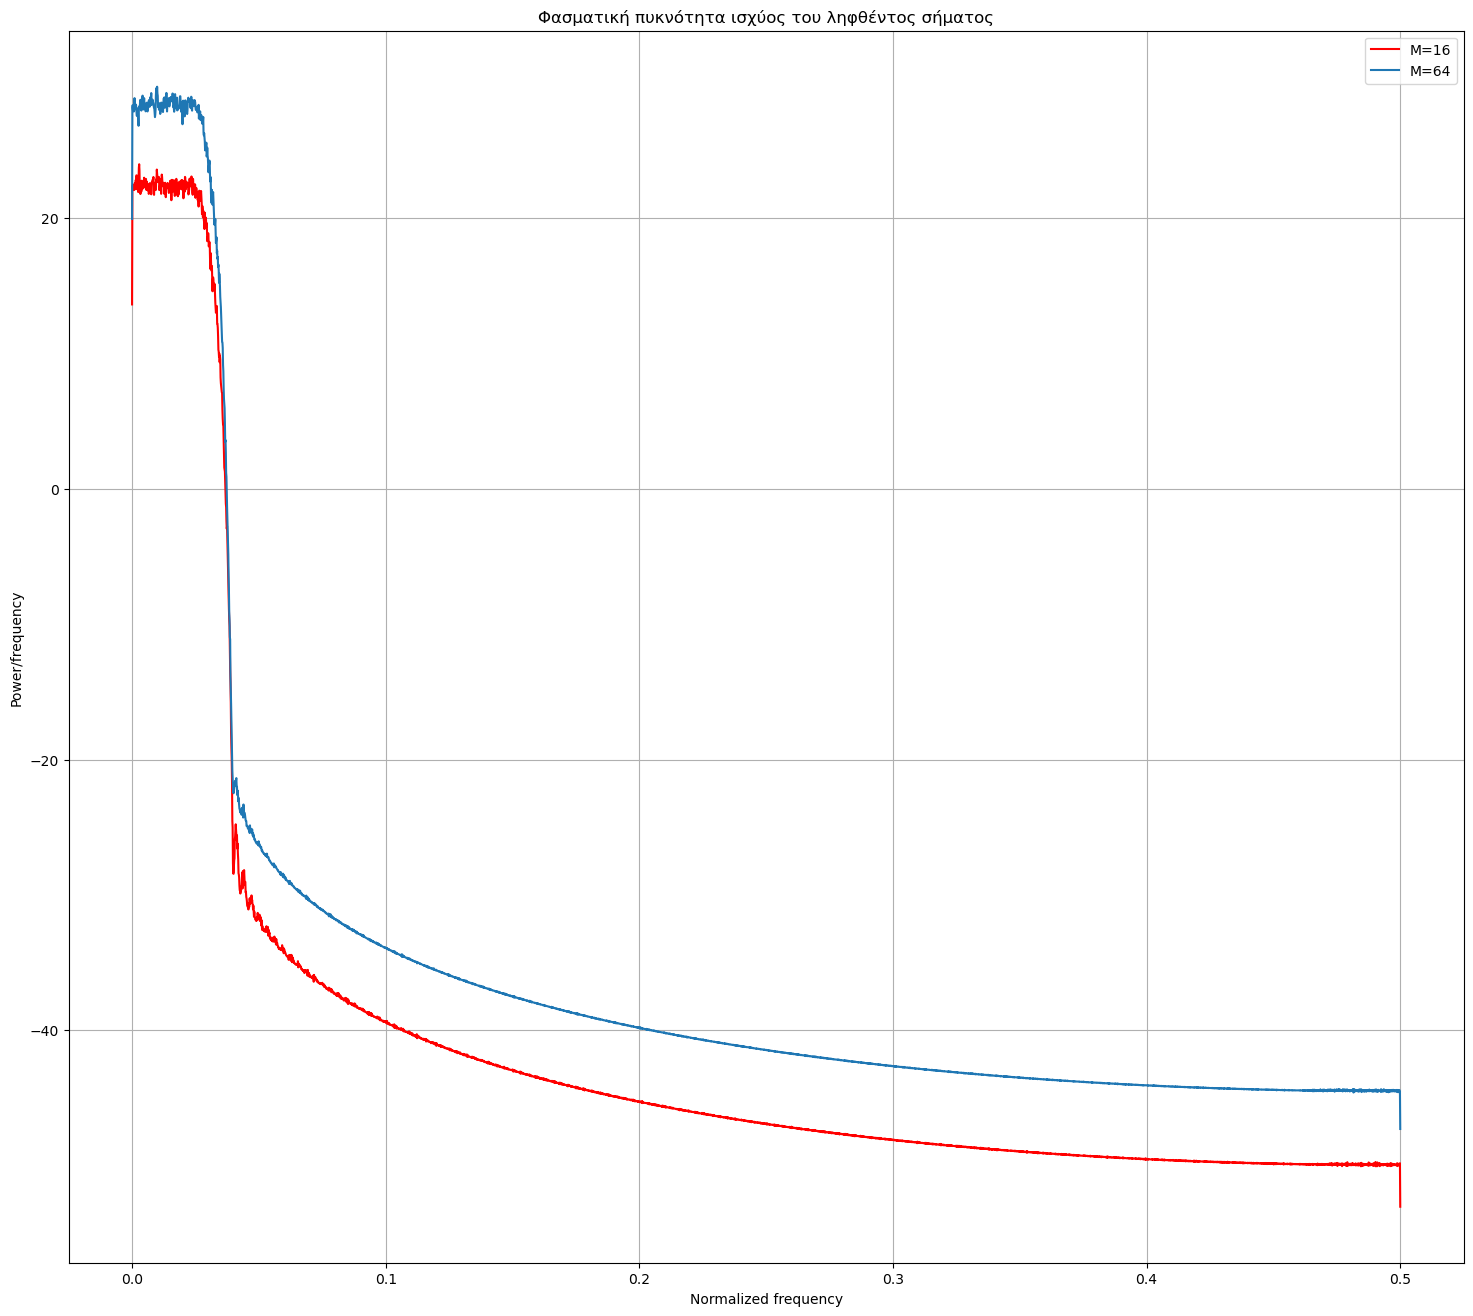

In [ ]:
# για μέγιστο Eb/N0=10db και μέγιστο Pb=0.002 βρίσκουμε από το σχήμα 5.11 
# ότι το κατάλληλο σύστημα είναι αυτό για Μ=16
# ο μέγιστος ρυθμός απόδοσης είναι: R<=log2(M)*W/(1+a)=8Mbps


def MQAM(L):
    a=0.25
    l=np.log2(L)
    k=2*l
    M=L**2
    Nsymb=30000
    # προσομοίωση πομπού
    nsamp=16
    fc=4
    SNR=L-10*np.log10(nsamp/k/2) #σε db
    core=[1+1j,1-1j,-1+1j,-1-1j]
    mapping=core[:]
    if(l>1):
        for j in range(1,int(l)):
            mapping=(list(map(lambda x:x+j*2*core[0],mapping)))
            conj_arr=np.conj(mapping)
            mapping= mapping + conj_arr.tolist()
            conj_arr=-np.conj(mapping)
            mapping= mapping + conj_arr.tolist()

    #παράγουμε τυχαία ακολουθία
    x=np.floor(2*np.random.rand(int(k*Nsymb),1))
    x_temp=np.reshape(x,(int(len(x)/(k)),int(k)))
    xsym=[]

    # χωρίζω τη λίστα σε επιμέρους λίστες και βάζω τα περιεχόμενα 
    #της καθεμίας σε ένα string ώστε με την εντολή int() να 
    # μετατραπεί από binary σε decimal
    for i in range(0,len(x_temp)):
        my_str=''
        y=x_temp[i]
        for j in range(0,int(np.log2(M))):
            my_str=my_str+str(int(y[j]))
        a=int(my_str, 2)
        xsym=xsym+[a]

    y=[]
    for n in range(0,len(xsym)):
        y=y + [mapping[xsym[n]]]

    delay=10
    filtorder= delay*nsamp*2
    rolloff=0.25

    shaping_filter=rootRaisedCosine(nsamp, rolloff, delay)
    ytx=upfirdn([1], y, nsamp) #upsample
    ytx=np.convolve(ytx,shaping_filter)
    m=np.arange(1,len(ytx)+1)
    s=np.real(np.multiply(ytx,np.exp(1j*2*np.pi*fc*m/nsamp)))

    s_matrix=np.matrix(s) #ανάστροφος
    s_matrix=s_matrix.getH()
    s_list=s_matrix.tolist()
    Ps=10*np.log10(np.matmul(s,s_list)/len(s)) #ισχύς μιγαδικού σήματος σε db
    Pn=Ps-SNR

    n=np.sqrt(10**(Pn/10))*np.random.randn(1,len(ytx))
    snoisy=s+n

    #δέκτης
    yrx=2*np.multiply(snoisy,np.exp(-1j*2*np.pi*fc*m/nsamp))
    yrx=yrx[0,:]
    yrx=np.convolve(yrx,shaping_filter)
    f, Pxx_den = scipy.signal.welch(np.real(yrx), window='hamming', nperseg=8196)
    return f,Pxx_den

# Υπολογίζουμε την φασματική πυκνότητα ισχύος του ληφθέντος σήματος
f,Pxx_den=MQAM(4)
Pxx_den = 10 * np.log10(Pxx_den)
fig = plt.figure(figsize=(18, 16))
plt.plot(f, Pxx_den,'r')
f,Pxx_den=MQAM(8)
Pxx_den = 10 * np.log10(Pxx_den)
plt.plot(f, Pxx_den)
plt.grid()
plt.title('Φασματική πυκνότητα ισχύος του ληφθέντος σήματος')
plt.xlabel('Normalized frequency')
plt.ylabel('Power/frequency')
plt.legend(['Μ=16', 'Μ=64'])
plt.show()


<font size="3">4) How much can the bit rate in question 3 be increased if the roll-off of the
Nyquist filter can be reduced by 50%;</font>

In [ ]:
#Για 64-QAM  M=64
W=(9.25-6.75)*(10**6)
a=0.125 # μειωθεί στο μισό του το roll-off του φίλτρου Nyquist
R=W*np.log2(64)/(1+a)
print("Nέος ρυθμός μετάδοσης" ,R/(10**6),"Mbps")


Nέος ρυθμός μετάδοσης 13.333333333333334 Mbps


<font size="3">5) (Optional) Simulate a PSK system, of the same modulation order and with the
same roll-off factor of Nyquist signals, as the QAM of question 3. Compare with
the latter (a) in terms of BER, (b) in terms of bandwidth, after designing the
BER-EbNo curve and the spectrum of the generated signal. Gray coding should
also be used here, implementing the procedure described in Frame 5.10 of the
Course Notes, with the help of the code:</font>

`````{tab} Python
````python
# The mapping vector for M-QAM Gray coding
# It is for a complete rectangular constellation, of dimension M=L^2
# l=log2(L): number of bits per dimension (inphase, quadrature)
core = np.array([1+1j, 1-1j, -1+1j, -1-1j]) # trivial case, M=4
mapping = core

if (l > 1):
    for k in range (1,l):
        mapping = mapping + k*2*core[0]
        mapping = np.array([mapping, np.conj(mapping)])
        mapping = np.array([mapping, (-np.conj(mapping))])
        
mapping = mapping.flatten().T

````
`````
`````{tab} Matlab
````matlab
% The mapping vector for M-PSK Gray coding
k=log2(M);
ph1=[pi/4];
theta=[ph1; -ph1; pi-ph1; -pi+ph1];
mapping=exp(1j*theta);
if(k>2)
 for j=3:k
 theta=theta/2;
 mapping=exp(1j*theta);
 mapping=[mapping; -conj(mapping)];
 theta=real(log(mapping)/1j);
 end
end

````
`````